In [1]:
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure

from skimage.measure import regionprops, label

from scipy.spatial import distance


/tmp/ipykernel_2972341/2028493022.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Labels from the mask: [  0   8   9  10  40  94 105 106 117 121]
Cell 1: {'Area': 75172.0, 'Perimeter': 2180.77878733769, 'Solidity': 0.761435922369434, 'Extent': 0.6484817115251897, 'Circularity': 0.1986290387825207, 'Convexity': 45.2700661677487, 'Elongation': 0.826191528550034, 'Compactness': 0.3824252300359386}
Cell 2: {'Area': 35084.0, 'Perimeter': 1400.025432638166, 'Solidity': 0.8709381128515751, 'Extent': 0.6510298756726666, 'Circularity': 0.22492986169453558, 'Convexity': 28.773048732473324, 'Elongation': 0.892228086129317, 'Compactness': 0.3183836665628814}
Cell 3: {'Area': 27339.0, 'Perimeter': 966.9970414071697, 'Solidity': 0.8244323150689062, 'Extent': 0.5665174686062414, 'Circularity': 0.3674025771561477, 'Convexity': 34.292762624944814, 'Elongation': 0.6611074313753333, 'Compactness': 0.5277509091738458}
Cell 4: {'Area': 75087.0, 'Perimeter': 2824.124025129251, 'Solidity': 0.5620284431137724, 'Extent': 0.4169623669348793, 'Circularity': 0.11830608591242286, 'Convexity': 4

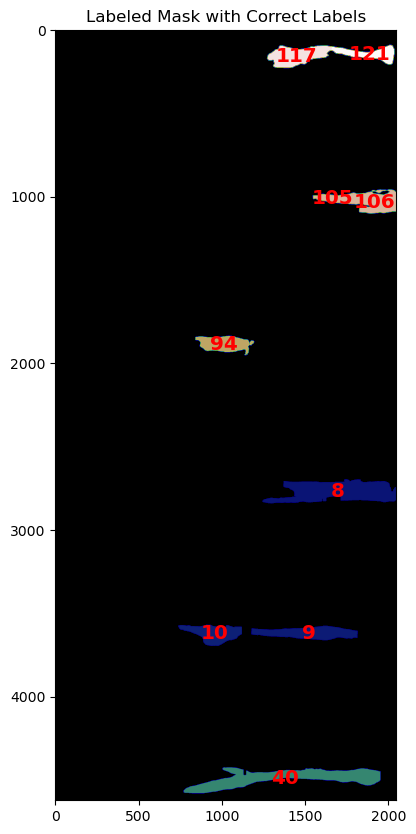

In [4]:
def analyze_mask_with_shape_factors(frame, mask_path_template, size_threshold=1000):
    

    def plot_labels(original, ax, title=None,
                    txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
                              'fontsize': 'x-large', 'fontweight': 'bold'},
                    cmap='gist_earth'):
        ax.imshow(original, cmap=cmap)
        labels = np.unique(original)
        print("Labels in plot_labels function:", labels)
        ax.set_title(title)
        for label in labels:
            if label != 0:  # Skip background label
                inds = np.argwhere(original == label)
                loc = inds.mean(0)
                ax.text(loc[1], loc[0], str(label), **txt_args)

    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = region.bbox_area
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        convexity = region.convex_image.sum() / perimeter if perimeter > 0 else 0
        
        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return {
            "Area": area,
            "Perimeter": perimeter,
            "Solidity": solidity,
            "Extent": extent,
            "Circularity": circularity,
            "Convexity": convexity,
            "Elongation": elongation,
            "Compactness": compactness,
        }

    # Load the mask image using imageio
    mask_path = mask_path_template.format(frame=frame)
    mask = imageio.imread(mask_path)

    # Print the labels directly from the mask
    unique_labels = np.unique(mask)
    print("Labels from the mask:", unique_labels)

    # Measure the properties of the labeled regions
    properties = regionprops(mask)

    # Apply a size threshold to filter out small artifacts
    filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

    # Calculate shape factors for filtered regions
    shape_factors_list = [calculate_shape_factors(region) for region in filtered_regions]

    # Display the results
    for idx, factors in enumerate(shape_factors_list):
        print(f"Cell {idx + 1}: {factors}")

    # Plot the labels for filtered cells, excluding the background label
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_labels(mask, ax, title="Labeled Mask with Correct Labels")
    plt.show()

# Example usage
frame = 65
# mask_path_template = "/path/to/mask_{frame:04d}.tif"  # Update the path
mask_path_template = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA/mask{frame:04d}.tif"
analyze_mask_with_shape_factors(frame, mask_path_template)


In [4]:
import os
from skimage.measure import regionprops, label
import numpy as np
import imageio
import pandas as pd
from scipy.spatial import distance  # For centroid matching

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """
    Analyze and track cells across multiple frames and store results by Cell ID.
    
    Parameters:
        mask_directory (str): Path to the directory containing mask files.
        output_directory (str): Path to the directory where the CSV file will be saved.
        size_threshold (int): Minimum size threshold for filtering small artifacts.
        max_centroid_dist (int): Maximum allowed distance to match cells across frames.
    
    Saves:
        A CSV file containing shape factor results with cells tracked across frames in the specified directory.
    """
    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = region.bbox_area
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        convexity = region.convex_image.sum() / perimeter if perimeter > 0 else 0
        
        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness]

    # Get all mask files in the directory, sorted by filename
    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    print(f"Found {len(mask_files)} mask files in the directory.")

    # To store cell tracking data
    all_results = []
    cell_tracks = {}  # Mapping of Cell ID to its most recent centroid

    current_cell_id = 1

    for frame_idx, mask_path in enumerate(mask_files):
        # Extract frame number from the filename (optional for tracking)
        frame = os.path.basename(mask_path).split('.')[0]

        # Load the mask image using imageio
        mask = imageio.imread(mask_path)

        # Measure the properties of the labeled regions
        properties = regionprops(mask)

        # Apply a size threshold to filter out small artifacts
        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        # Prepare a mapping for this frame
        frame_results = []

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = region.centroid

            # Attempt to match this cell with an existing cell track
            matched_cell_id = None
            for cell_id, prev_centroid in cell_tracks.items():
                if distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    break

            if matched_cell_id is None:
                # No match found; assign a new Cell ID
                matched_cell_id = current_cell_id
                current_cell_id += 1

            # Update the cell's most recent centroid
            cell_tracks[matched_cell_id] = centroid

            # Append results: Cell ID, Frame, and Shape Factors
            frame_results.append([matched_cell_id, frame] + shape_factors)

        # Add frame results to the main results
        all_results.extend(frame_results)

        print(f"Processed frame {frame}: {len(filtered_regions)} cells detected.")

    # Define column names
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent",
               "Circularity", "Convexity", "Elongation", "Compactness"]

    # Convert results to a DataFrame
    results_df = pd.DataFrame(all_results, columns=columns)

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Save results to the specified output directory
    output_file_path = os.path.join(output_directory, "tracked_cells_across_frames.csv")
    results_df.to_csv(output_file_path, index=False)
    print(f"Results saved to {output_file_path}")

    return results_df

# Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"  # Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"  # Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head())



Found 100 mask files in the directory.
Processed frame mask0000: 12 cells detected.


/tmp/ipykernel_2974488/1763024439.py:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Processed frame mask0001: 12 cells detected.
Processed frame mask0002: 12 cells detected.
Processed frame mask0003: 12 cells detected.
Processed frame mask0004: 13 cells detected.
Processed frame mask0005: 12 cells detected.
Processed frame mask0006: 12 cells detected.
Processed frame mask0007: 12 cells detected.
Processed frame mask0008: 11 cells detected.
Processed frame mask0009: 11 cells detected.
Processed frame mask0010: 11 cells detected.
Processed frame mask0011: 12 cells detected.
Processed frame mask0012: 11 cells detected.
Processed frame mask0013: 11 cells detected.
Processed frame mask0014: 10 cells detected.
Processed frame mask0015: 9 cells detected.
Processed frame mask0016: 10 cells detected.
Processed frame mask0017: 9 cells detected.
Processed frame mask0018: 9 cells detected.
Processed frame mask0019: 10 cells detected.
Processed frame mask0020: 11 cells detected.
Processed frame mask0021: 10 cells detected.
Processed frame mask0022: 10 cells detected.
Processed fra

In [5]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """
    Analyze and track cells across multiple frames and store results by Cell ID.
    
    Parameters:
        mask_directory (str): Path to the directory containing mask files.
        output_directory (str): Path to the directory where the CSV file will be saved.
        size_threshold (int): Minimum size threshold for filtering small artifacts.
        max_centroid_dist (int): Maximum allowed distance to match cells across frames.
    
    Saves:
        A CSV file containing shape factor results with cells tracked across frames in the specified directory.
    """
    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = region.bbox_area
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        convexity = region.convex_image.sum() / perimeter if perimeter > 0 else 0
        
        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness]

    # Get all mask files in the directory, sorted by filename
    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    print(f"Found {len(mask_files)} mask files in the directory.")

    # To store cell tracking data
    all_results = []
    cell_tracks = {}  # Mapping of Cell ID to its most recent centroid

    current_cell_id = 1

    for mask_path in mask_files:
        # Extract frame number from the filename
        frame = os.path.basename(mask_path).split('.')[0]

        # Load the mask image using imageio
        mask = imageio.imread(mask_path)

        # Measure the properties of the labeled regions
        properties = regionprops(mask)

        # Apply a size threshold to filter out small artifacts
        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = region.centroid

            # Attempt to match this cell with an existing cell track
            matched_cell_id = None
            for cell_id, prev_centroid in cell_tracks.items():
                if distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    break

            if matched_cell_id is None:
                # No match found; assign a new Cell ID
                matched_cell_id = current_cell_id
                current_cell_id += 1

            # Update the cell's most recent centroid
            cell_tracks[matched_cell_id] = centroid

            # Append results: Cell ID, Frame, and Shape Factors
            all_results.append([matched_cell_id, frame] + shape_factors)

    # Define column names
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent",
               "Circularity", "Convexity", "Elongation", "Compactness"]

    # Convert results to a DataFrame
    results_df = pd.DataFrame(all_results, columns=columns)

    # Sort by Cell Number and Frame
    results_df = results_df.sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Save results to the specified output directory
    output_file_path = os.path.join(output_directory, "tracked_cells_across_frames.csv")
    results_df.to_csv(output_file_path, index=False)
    print(f"Results saved to {output_file_path}")

    return results_df

# Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"  # Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"  # Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head())


Found 100 mask files in the directory.


/tmp/ipykernel_2974488/451183901.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Results saved to /home/MinaHossain/DMNet_Rina_Tracking/tracked_cells_across_frames.csv
   Cell Number     Frame     Area    Perimeter  Solidity    Extent  \
0            1  mask0000  19221.0  1319.688384  0.736014  0.493961   
1            1  mask0022  15870.0   992.048773  0.815896  0.644493   
2            1  mask0026  23669.0  1603.244733  0.796480  0.563279   
3            2  mask0000  19719.0   728.676190  0.825063  0.617299   
4            2  mask0001  20319.0   693.605122  0.842553  0.611834   

   Circularity  Convexity  Elongation  Compactness  
0     0.138689  19.788763    0.938314     0.226238  
1     0.202638  19.606899    0.908014     0.285745  
2     0.115715  18.535536    0.945193     0.217443  
3     0.466687  32.799205    0.562733     0.603899  
4     0.530747  34.769063    0.569925     0.602088  
